# Реализация сиамской нейронной сети

### импорт необходимых библиотек

In [2]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install neurokit2

In [ ]:
pip install wfdb

In [ ]:
pip install keras==2.11.0

In [ ]:
pip install tensorflow==2.11.0

In [3]:
import wfdb
import pandas as pd
from sklearn import preprocessing
import numpy as np

import keras.backend as K
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt

### загрузка датасета

In [4]:
import os

X = []

for root, dirs, files in os.walk('./ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records100/'):
    for file in files:
        if file.endswith('.dat'):
            file_path = root+"/"+file[:-4]
            try:
                data = wfdb.rdsamp(file_path)
                data = data[0][:,7]
                X.append(data)
            except Exception:
                    print("Can't find file "+file_path)

print(len(X))

21799


### подготовка данных

In [5]:
df = pd.DataFrame(X)
df_1 = pd.DataFrame(preprocessing.normalize(df))
center_function = lambda x: x - x.mean()
df_1 = center_function(df_1)

### перемешиваю записи

In [6]:
from sklearn.utils import shuffle
df_2 = shuffle(df_1,random_state=20)

### создание пары ЭКГ

In [7]:
def make_pair(data):
  X = []
  Y = []
  for i in range(len(data)-1):
    row_main = data.iloc[i][:500].values
    row_same = data.iloc[i][500:1000].values
    row_neg = data.iloc[i+1][:500].values
    X.append([row_main,row_same])
    X.append([row_main,row_neg])
    Y.append(0)
    Y.append(1)

  return np.array(X), np.array(Y)

X, Y = make_pair(df_2)

### разделение выботки на обучающую и тестовую

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### создание нейронной сети

In [21]:
def create_base_network(input_shape):
    model_cnn = Sequential()
    model_cnn.add(Conv1D(512, 5,  padding='valid', activation='relu'))
    model_cnn.add(Conv1D(256, 5,  padding='valid', activation='relu'))
    model_cnn.add(Conv1D(128, 5,  padding='valid', activation='relu'))
    model_cnn.add(Conv1D(64, 5,  padding='valid', activation='relu'))
    model_cnn.add(GlobalMaxPooling1D())
    model_cnn.add(Dense(units=32, activation='relu', kernel_regularizer='l2'))
    model_cnn.add(Dense(16, activation='softmax'))
    return model_cnn
input_shape = 500
base_network = create_base_network(input_shape)

input_a = Input(shape=(input_shape, 1))
input_b = Input(shape=(input_shape,1 ))

processed_a = base_network(input_a)
processed_b = base_network(input_b)


def euclidean_distance(vects):
    v1, v2 = vects
    return K.sqrt(K.sum(K.square(v1 -v2), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

distance = Lambda(function=euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)


model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, 16)           866288      ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 1)            0           ['sequential_1[0][0]',     

### обучение нейронной сети

In [22]:
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred > 0.4, y_true.dtype)))

rmsprop = RMSprop()
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=[accuracy])
history = model.fit(x=[X_train[:, 0], X_train[:, 1]], y=y_train.astype('float32'), batch_size=20, epochs=12,validation_split=0.2,verbose=1)

Epoch 1/12
1395/1395 [==============================] - 810s 580ms/step - loss: 0.5097 - accuracy: 0.8595 - val_loss: 0.3330 - val_accuracy: 0.9086
Epoch 2/12
1395/1395 [==============================] - 807s 578ms/step - loss: 0.3265 - accuracy: 0.9014 - val_loss: 0.3047 - val_accuracy: 0.9099
Epoch 3/12
1395/1395 [==============================] - 805s 577ms/step - loss: 0.2792 - accuracy: 0.9111 - val_loss: 0.2675 - val_accuracy: 0.9163
Epoch 4/12
1395/1395 [==============================] - 813s 583ms/step - loss: 0.2736 - accuracy: 0.9087 - val_loss: 0.2698 - val_accuracy: 0.9121
Epoch 5/12
1395/1395 [==============================] - 805s 577ms/step - loss: 0.2568 - accuracy: 0.9139 - val_loss: 0.2353 - val_accuracy: 0.9223
Epoch 6/12
1395/1395 [==============================] - 803s 576ms/step - loss: 0.2551 - accuracy: 0.9162 - val_loss: 0.2432 - val_accuracy: 0.9242
Epoch 7/12
1395/1395 [==============================] - 822s 590ms/step - loss: 0.2443 - accuracy: 0.9192 - val_

In [23]:
acc_train = history.history["accuracy"]
loss_train = history.history["loss"]
acc_val = history.history["val_accuracy"]
loss_val = history.history["val_loss"]

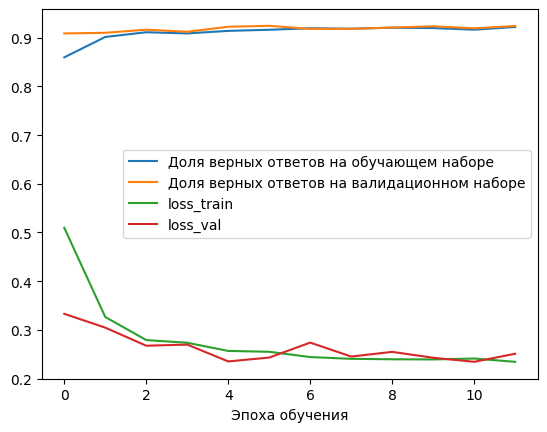

In [24]:
plt.plot(acc_train,
         label='Доля верных ответов на обучающем наборе')
plt.plot(acc_val,
         label='Доля верных ответов на валидационном наборе')
plt.plot(loss_train,
         label='loss_train')
plt.plot(loss_val,
         label='loss_val')
plt.xlabel('Эпоха обучения')
# plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### проверка на тестовых данных

In [25]:
score = model.evaluate(x=[X_test[:,0],X_test[:,1]],y=y_test.astype('float32'))

273/273 [==============================] - 53s 193ms/step - loss: 0.2301 - accuracy: 0.9235


### сохранение и загрузка модели

In [26]:
#model.save("./model.h5")
model.save_weights('weight_v3.h5')

In [34]:
# model.load_weights('weight_v2.h5', skip_mismatch=False)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, 16)           866288      ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 1)            0           ['sequential_1[0][0]',     

### метрики качества работы модели

In [27]:
y_pred = model.predict(x=[X_test[:,0],X_test[:,1]])

273/273 [==============================] - 55s 199ms/step


In [30]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
def quality_metrics(y, y_pred):
  c_matrix = confusion_matrix(y, y_pred)
  c =0
  for i in range(len(y_pred)):
    if y_pred[i]==y[i]:
      c=c+1
  accuracy = c/len(y_pred)
  precision = c_matrix[0][0]/(c_matrix[0][0]+c_matrix[0][1])
  recall = c_matrix[0][0]/(c_matrix[0][0]+c_matrix[1][0])
  F1 = 2*precision*recall/(precision+recall)
  print(f'accuracy = {accuracy}\npresicion = {precision}\nrecall = {recall}\nF1 = {F1}\n')

In [31]:
y = []
for i in range(len(y_pred)):
  tmp = y_pred[i]
  if tmp < 0.4:
    y.append(0)

  else:
    y.append(1)

In [32]:
confusion_matrix(y_test, y)

array([[4202,  108],
       [ 560, 3850]], dtype=int64)

In [33]:
quality_metrics(y_test, y)

accuracy = 0.923394495412844
presicion = 0.9749419953596288
recall = 0.8824023519529609
F1 = 0.9263668430335097

